In [2]:
%pylab inline
import numpy as np
import numpy.random as rand
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import random as rng
import seaborn as sns
import pickle
import argparse
import pandas as pd 
import pickle
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


In [1]:
cd /home/lansdell/projects/synthfeedback

/home/lansdell/projects/synthfeedback


## Backprop w autograd

In [3]:
#Load data from script
model = 'bpauto'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']

In [4]:
print(metrics.shape)
tags

(1, 3, 1001, 13)


['loss',
 'acc',
 'loss_test',
 'acc_test',
 'align_B2',
 'norm_W2_B2',
 'sign_cong2',
 'align_B3',
 'norm_W3_B3',
 'sign_cong3',
 'align_B4',
 'norm_W4_B4',
 'sign_cong4']

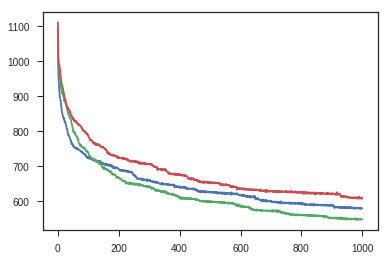

In [8]:
#Plot loss:
loss = metrics[0,:,:,0].T
loss.shape
plt.plot(loss)

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


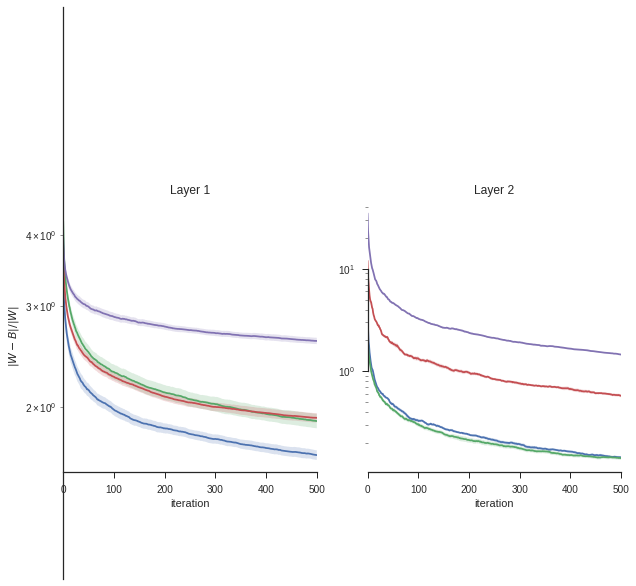

In [9]:
#Plot norms
var_xi = [1e-3, 1e-2, 1e-1, 1]
N = 4

idx = 5
fig,axes = plt.subplots(1,2,figsize=(10,5))
for i in range(N):
    sns.tsplot(metrics[i,:,:,idx], ax = axes[0], color='C%d'%i)
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('$\|W-B\|/\|W\|$');
axes[0].set_title('Layer 1');
axes[0].set_yscale('log')

idx = 7
for i in range(N):
    sns.tsplot(metrics[i,:,:,idx], ax = axes[1], color='C%d'%i)
axes[1].set_xlabel('iteration');
axes[1].set_title('Layer 2');
axes[1].set_yscale('log')
sns.despine(trim=True)

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


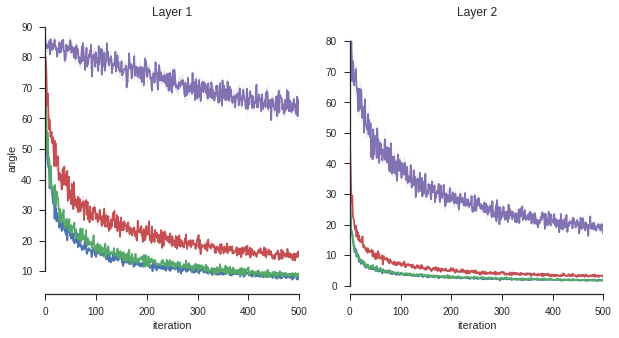

In [11]:
#Plot alignment
#Plot norms
var_xi = [1e-3, 1e-2, 1e-1, 1]
N = 4

idx = 4
fig,axes = plt.subplots(1,2,figsize=(10,5))
for i in range(N):
    sns.tsplot(metrics[i,:,:,idx], ax = axes[0], color='C%d'%i)
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('angle');
axes[0].set_title('Layer 1');

idx = 6
for i in range(N):
    sns.tsplot(metrics[i,:,:,idx], ax = axes[1], color='C%d'%i)
axes[1].set_xlabel('iteration');
axes[1].set_title('Layer 2');
sns.despine(trim=True)

In [12]:
metrics[:,0,-1,6]

array([ 1.94601631,  2.28713059,  3.31741405, 21.30862045])

## Backprop w selfgrad

In [9]:
#Load data from script
model = 'bpself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']

In [10]:
print(metrics.shape)
tags

(1, 3, 1001, 13)


['loss',
 'acc',
 'loss_test',
 'acc_test',
 'align_B2',
 'norm_W2_B2',
 'sign_cong2',
 'align_B3',
 'norm_W3_B3',
 'sign_cong3',
 'align_B4',
 'norm_W4_B4',
 'sign_cong4']

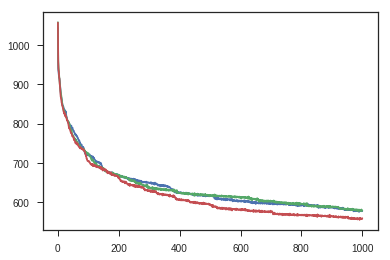

In [11]:
#Plot loss:
loss = metrics[0,:,:,0].T
loss.shape
plt.plot(loss)

## Feedback alignment w autograd

In [12]:
#Load data from script
model = 'faauto'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']

In [13]:
print(metrics.shape)
tags

(1, 3, 1001, 13)


['loss',
 'acc',
 'loss_test',
 'acc_test',
 'align_B2',
 'norm_W2_B2',
 'sign_cong2',
 'align_B3',
 'norm_W3_B3',
 'sign_cong3',
 'align_B4',
 'norm_W4_B4',
 'sign_cong4']

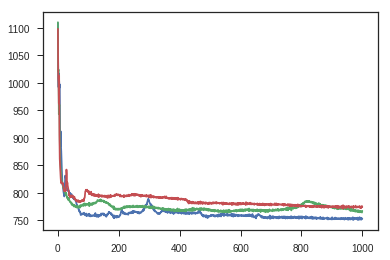

In [14]:
#Plot loss:
loss = metrics[0,:,:,0].T
loss.shape
plt.plot(loss)

## Feedback alignment w selfgrad

In [15]:
#Load data from script
model = 'faself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']

In [16]:
print(metrics.shape)
tags

(1, 3, 1001, 13)


['loss',
 'acc',
 'loss_test',
 'acc_test',
 'align_B2',
 'norm_W2_B2',
 'sign_cong2',
 'align_B3',
 'norm_W3_B3',
 'sign_cong3',
 'align_B4',
 'norm_W4_B4',
 'sign_cong4']

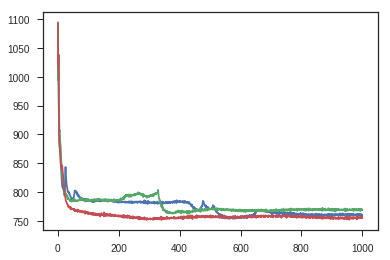

In [17]:
#Plot loss:
loss = metrics[0,:,:,0].T
loss.shape
plt.plot(loss)

## Nodepert w selfgrad

In [20]:
#Load data from script
fn_in = './experiments/nodepert_ae5_warmup/summary/3_autoencoder.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']

In [21]:
print(metrics.shape)
tags

(4, 1, 1001, 13)


['loss',
 'acc',
 'loss_test',
 'acc_test',
 'align_B2',
 'norm_W2_B2',
 'sign_cong2',
 'align_B3',
 'norm_W3_B3',
 'sign_cong3',
 'align_B4',
 'norm_W4_B4',
 'sign_cong4']

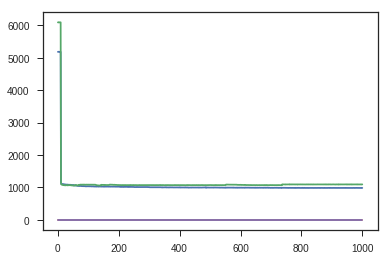

In [23]:
#Plot loss:
loss = metrics[:,0,:,0].T
loss.shape
plt.plot(loss)

## Plot all on same curve

In [53]:
#Load BP data from script
model = 'bpself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_bp_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_BP = metrics[0,:,:,0]

#Load FA data
model = 'faself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_fa_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_FA = metrics[0,:,:,0]


#Load NP data
fn_in = './experiments/nodepert_ae5_sgd_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_NP = metrics[:,0,:,0].T

In [54]:
metrics.shape

(1, 1, 501, 13)

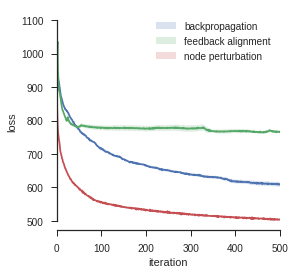

In [57]:
fig,axes = plt.subplots(1,1,figsize=(4,4))

sns.tsplot(loss_BP, ax = axes, color='C0')
sns.tsplot(loss_FA, ax = axes, color='C1')
sns.tsplot(np.squeeze(loss_NP), ax = axes, color='C2')

axes.legend(['backpropagation', 'feedback alignment', 'node perturbation'])
#axes.set_yscale('log')
axes.set_xlabel('iteration');
#axes.set_ylim([450, 1200])
axes.set_ylabel('loss')
sns.despine(trim=True)
plt.savefig('./figures/3_autoencoder_losses.pdf')